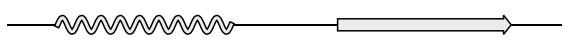

In [28]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.database.rcsb as rcsb
import biotite.database.entrez as entrez
import biotite.application.dssp as dssp


# Create 'FeaturePlotter' subclasses
# for drawing the scondary structure features

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=6, color='k',zorder=1
        )
        axes.plot(
            x_val, y_val, linewidth=3, color='#EBEBEB',zorder=2
        )

class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0

        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height*(2/3), self._head_width*bbox.height*(2/3),
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.4, draw_head=draw_head,
            facecolor="#EBEBEB", edgecolor='black',linewidth=1.5,zorder=2
        ))


# Test our drawing functions with example annotation
annotation = seq.Annotation([
    seq.Feature("SecStr", [seq.Location(10, 40)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(60, 90)], {"sec_str_type" : "sheet"}),
])

fig = plt.figure(figsize=(8.0, 0.8))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax, annotation, multi_line=False, loc_range=(1,100),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
fig.tight_layout()

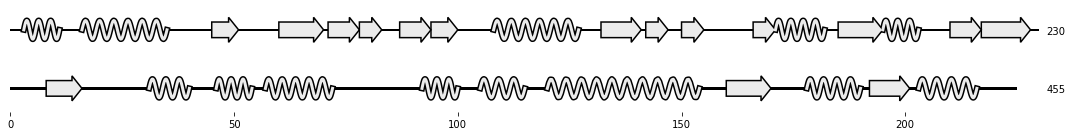

In [29]:
file_name = entrez.fetch("1V4S_A", gettempdir(), "gb", "protein", "gb")
gb_file = gb.GenBankFile.read(file_name)
annotation = gb.get_annotation(gb_file, include_only=["SecStr"])
# Length of the sequence
_, length, _, _, _, _ = gb.get_locus(gb_file)

fig = plt.figure(figsize=(15.0, 2.0))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax, annotation, symbols_per_line=230,
    show_numbers=True, show_line_position=True,
    # 'loc_range' takes exclusive stop -> length+1 is required
    loc_range=(1,length+1),
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
fig.tight_layout()

plt.savefig('../figures/GCK_secondary_structure_annot.pdf')